In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp
import numba as nb

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 20

mtype = "small_world"
n = 500
G = nx.connected_watts_strogatz_graph(n, k=4, p=0.1)
G.remove_edges_from(nx.selfloop_edges(G))


n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

for u, v in G.edges():
    G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=500, G.number_of_edges()=1000
in  degrees: {0: 0, 1: 0, 2: 3, 3: 77, 4: 342, 5: 73, 6: 5}
out degrees: {0: 0, 1: 0, 2: 3, 3: 77, 4: 342, 5: 73, 6: 5}


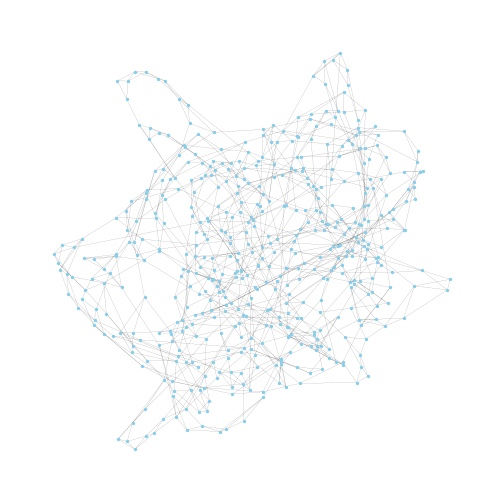

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([0.00374791, 0.02070258, 0.04138741, 0.01569287, 0.00061709]),
 array([ 0.        , 12.17316944, 24.34633888, 36.51950832, 48.69267776,
        60.8658472 ]))

In [6]:
adjacency_list = ldr.adjacency_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=True


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([0.10560921, 0.10661024, 0.09359679, 0.1026061 , 0.09209523]),
 array([9.81857711e-03, 2.00775041e+00, 4.00568224e+00, 6.00361407e+00,
        8.00154590e+00, 9.99947774e+00]))

In [9]:
info = {} 

In [10]:
nsamples = int(np.sqrt(n))
print(f"{nsamples=}")
pi = np.random.permutation(n)[:nsamples]

pi_c = np.delete(np.arange(n), pi)

rDist = Dist[pi]

nsamples=22


In [11]:
X0 = np.random.randn(n, rank)

In [12]:
B = ldr.symm_B_matrix(X0, n, rDist, pi)

B2 = np.zeros((n, n))
dists_ij, _ = ldr.eulidean_dist_matrix(X0)
for i in pi:
    for j in range(n):
        if j == i or not np.allclose(B2[i, j], 0) or np.allclose(dists_ij[i, j], 0): continue
        assert np.allclose(Dist[i, j] / dists_ij[i, j], Dist[j, i] / dists_ij[j, i])
        ratio = Dist[i, j] / dists_ij[i, j]
        B2[i, i] += ratio
        B2[j, j] += ratio
        B2[i, j] += -ratio
        B2[j, i] += -ratio

assert np.allclose(B, B2) and (np.allclose(np.linalg.norm(B.sum(axis=0)), 0) and np.allclose(np.linalg.norm(B.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(B2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(B2.sum(axis=1)), 0))
print("PASSED")

PASSED


In [13]:
for _ in range(10):
    X = np.random.randn(n, rank)

    d_X = np.einsum('ik,ik->i', X, X)
    
    res = ldr.symm_product_BZ(X, d_X, pi, pi_c, rDist)

    B = ldr.symm_B_matrix(X, n, rDist, pi)
    res_true = B @ X
    assert np.allclose(res, res_true), print(mf.rel_diff(res, res_true))
print("PASSED")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


PASSED


In [14]:
%timeit ldr.symm_product_BZ(X, d_X, pi, pi_c, rDist)

12.5 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit ldr.symm_B_matrix(X, n, rDist, pi) @ X

11.4 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


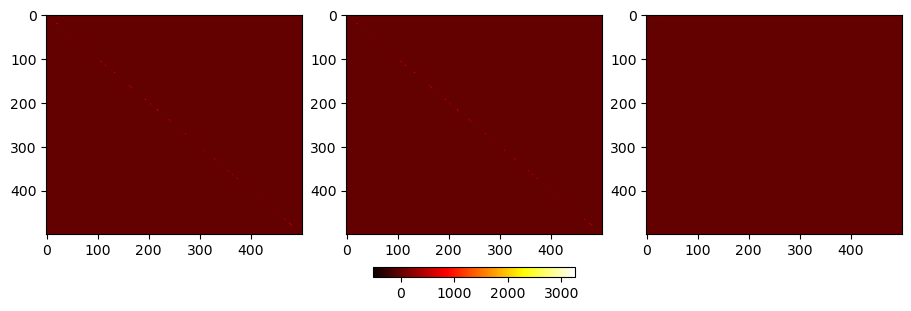

In [16]:
vmin = min(np.min(B), np.min(B2), np.min(B2-B))
vmax = max(np.max(B), np.max(B2), np.max(B2-B))

fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im1 = axs[0].imshow(B, aspect='auto', cmap='hot', vmin=vmin, vmax=vmax)
im2 = axs[1].imshow(B2, aspect='auto', cmap='hot', vmin=vmin, vmax=vmax)
im3 = axs[2].imshow(B2-B, aspect='auto', cmap='hot', vmin=vmin, vmax=vmax)

cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.04)

plt.show()

In [17]:
L = ldr.laplacian_from_pi(pi, n, debug=True)

In [18]:
L2 = np.zeros((n, n))

for i in pi:
    for j in range(n):
        if j == i or L2[i, j] == -1: continue
        L2[i, i] += 1
        L2[j, j] += 1
        L2[i, j] = -1
        L2[j, i] = -1

assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))
# print(L2,"\n\n",  L)
print("PASSED")

PASSED


In [19]:
for i in range(n):
    b0 = np.eye(n)[i]
    res3 = L @ b0
    res1 = ldr.symm_product_Lb(b0, pi, pi_c, n)
    assert np.allclose(res1, res3)
print("PASSED")

PASSED


In [20]:
Z, loss, losses = ldr.fast_cc(rank, pi_rows=pi, pi_rows_c=pi_c, rDist=rDist, symm=True, n_init=5,
                   max_iter=2000, eps=1e-6, verbose=True, freq=500)

/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  rho0 = np.dot(r, z)
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  losses[k] = np.sqrt(np.dot(r, r)) / b_norm


t=0, loss=1221.3969012918878
t=500, loss=9.183327899814355
865
loss=9.17431871792557, np.diff(np.array(losses)).max()=0.0
t=0, loss=9.174309606753923
1
loss=9.174300534248871, np.diff(np.array(losses)).max()=0.0
t=0, loss=9.174291500221452
1
loss=9.174282504483775, np.diff(np.array(losses)).max()=0.0
t=0, loss=9.174273546849006
1
loss=9.174264627131365, np.diff(np.array(losses)).max()=0.0
t=0, loss=9.174255745146116
1
loss=9.174246900709567, np.diff(np.array(losses)).max()=0.0


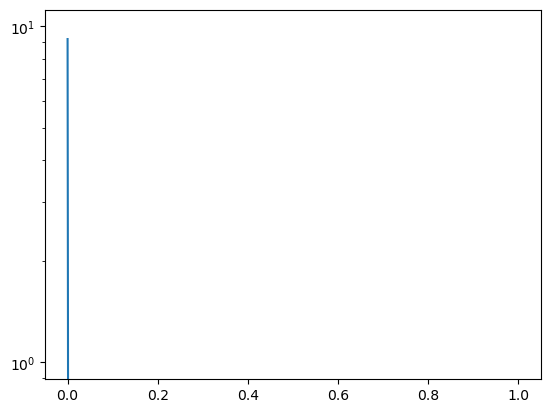

In [21]:
plt.plot(losses)
plt.yscale('log')

In [22]:
l_dar = ldr.construct_node_embedding_graph(Z, adjacency_list)
_ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}

%[ratio<2] = 72.40%, %[ratio<1.2] = 49.80%, %[ratio=1.] = 28.70%


In [23]:
Z_rand = np.random.randn(Z.shape[0], Z.shape[1])
l_dar = ldr.construct_node_embedding_graph(Z_rand, adjacency_list)
_ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}

%[ratio<2] = 5.30%, %[ratio<1.2] = 2.30%, %[ratio=1.] = 1.70%


# MDS check

In [24]:
row_indices = np.repeat(pi, n)
col_indices = np.tile(np.arange(n), pi.size)
values = Dist[pi].flatten('C')
pi_Dist = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))

In [25]:
X_mds, stress = ldr.l2_full_convex_concave(rank, pi, pi_Dist, n_init=2, max_iter=1000, eps=1e-6, verbose=True, freq=500, debug=True)
mds_dar = ldr.construct_node_embedding_graph(X_mds, adjacency_list)
_ = {'ratios' : ldr.subopt_ratios(mds_dar, Dist, sources, targets)}

t=0, loss=1220.7643531173096
t=500, loss=9.181082840544908
816
loss=9.174206282707447
t=0, loss=1216.491006587841
t=500, loss=9.18276737633406
853
loss=9.174580438517516
%[ratio<2] = 72.40%, %[ratio<1.2] = 49.50%, %[ratio=1.] = 28.50%
